<a href="https://colab.research.google.com/github/AugustinCablant/Viager/blob/main/Estimation_fonction_survie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation de la fonction de survie

## Importations

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Stage')
from tqdm import tqdm
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Charger et mettre en place les données

In [94]:
# Download Data

#df = pd.read_stata('data_tetes_back_match.dta')

#df.head()

#df.to_csv('data_tetes_back_match.csv')

df = pd.read_csv('data_tetes_back_match.csv')

In [40]:
df[['dateN','dateD']].head()


,dateN,dateD
0,-14750.0,16485.0
1,-12643.0,15592.0
2,-20582.0,13568.0
3,-16541.0,15680.0
4,-17541.0,13534.0


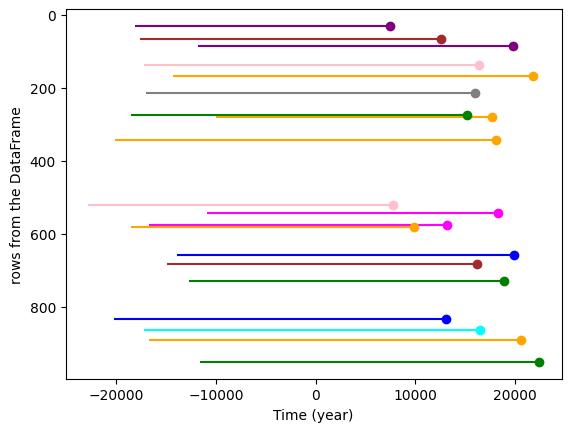

In [42]:
# Get a randomized sample
samp = df.sample(n=20, random_state=42)

# Colors in matplotlib.pyplot
avaidable_colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta']
avaidable_colors

def plot_lifelines(obs):
    """Plot a line for each observation.

    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['dateN']
        end = row['dateD']

        color = random.choice(avaidable_colors)
        plt.hlines(y, start, end, color=color)
        plt.plot(end, y, marker='o', color=color)

    plt.xlabel('Time (year)')
    plt.ylabel('rows from the DataFrame')
    plt.gca().invert_yaxis()

plot_lifelines(samp)

In [96]:
# Create Td and Ts (lifetime in days)
df['Td'] = df['dateD'] - df['dateN']
df['Ts'] = df['dateD'] - df['dateA']
#df.to_csv('data_tetes_back_match.csv')

In [44]:
# Variable Td
print("Descriptive statistics on variable Td : \n", df['Td'].describe())
print("\n")

# Make it easier to read

df['Td_age'] = df['Td']/365

print("Descriptive statistics on variable Td_age : \n", df['Td_age'].describe())
print("\n")

# Variable Ts
print("Descriptive statistics on variable Ts : \n", df['Ts'].describe())
print("\n")

# Make it easier to read

df['Ts_age'] = df['Ts']/365

print("Descriptive statistics on variable Td_age : \n", df['Ts_age'].describe())
print("\n")

Descriptive statistics on variable Td : 
 count      956.000000
mean     32298.490234
std       2675.034668
min      23431.000000
25%      30588.000000
50%      32585.000000
75%      34145.750000
max      38706.000000
Name: Td, dtype: float64


Descriptive statistics on variable Td_age : 
 count    956.000000
mean      88.489006
std        7.328862
min       64.194519
25%       83.802738
50%       89.273975
75%       93.549999
max      106.043839
Name: Td_age, dtype: float64


Descriptive statistics on variable Ts : 
 count      956.000000
mean      4854.049316
std       2975.211914
min        -55.000000
25%       2553.000000
50%       4555.500000
75%       6893.000000
max      14448.000000
Name: Ts, dtype: float64


Descriptive statistics on variable Td_age : 
 count    956.000000
mean      13.298765
std        8.151265
min       -0.150685
25%        6.994521
50%       12.480822
75%       18.884932
max       39.583561
Name: Ts_age, dtype: float64




**What is the Kaplan-Meier estimator?** <br>
<br>
The Kaplan-Meier (KM) estimator is a non-parametric statistic that estimates the survival function of time-to-event data. <br>
<br>
We note : <br>
- $t_i \space \text{a duration time} $
- $ d_i \space \text{number of events that happened at time} \space t_i$
- $n_i \space \text{number of individuals known to have survived up to time}$ <br>
Then, the survival function $S(t)$ is estimated with: $\displaystyle \prod_{i:t_i \le t} (1 - \frac{d_i}{n_i})$.

Here, our variables are doubly truncated. On the one hand, we can carry out the observation if and only if the individual died before June 2023. Secondly, we consider the survival period from the date on which the life annuity contract was signed.  <br>Let's give a few notations :
<br> <br>
$T_i$ is the lifetime of the seller, $T_{i,birth}$ the date of birth of seller $i$, $T_c$ the date of the contract signature and $T_{end}$ 1 June 2023. <br>
People $i$ is included in the sample if and only if: <br> $$ T_{i,birth} + T_i \le T_{end} \space \space \text{and} \space \space T_{i,birth} + T_i \ge T_c$$.

### Get some training with data_back_match dataset (does not include clones)

In [60]:
# Kaplan-Meier estimation

kmf = KaplanMeierFitter()
Ts = df.sort_values(by = 'Ts',ascending=True)
n = Ts.shape[0]
E = [1]*n
kmf.fit(Ts['Ts'], E)
kmf.survival_function_

,KM_estimate
timeline,
-55.0,0.998954
-1.0,0.997908
15.0,0.996862
22.0,0.995816
69.0,0.994770
...,...
13191.0,0.004184
13295.0,0.003138
13592.0,0.002092


In [61]:
# Confidence interval
ci = kmf.confidence_interval_survival_function_
ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
-55.0,0.992598,0.999853
-1.0,0.991661,0.999476
15.0,0.990302,0.998987
22.0,0.988891,0.998428
69.0,0.987481,0.997820
...,...,...
13191.0,0.001434,0.010246
13295.0,0.000901,0.008755
13592.0,0.000443,0.007230
13607.0,0.000108,0.005750


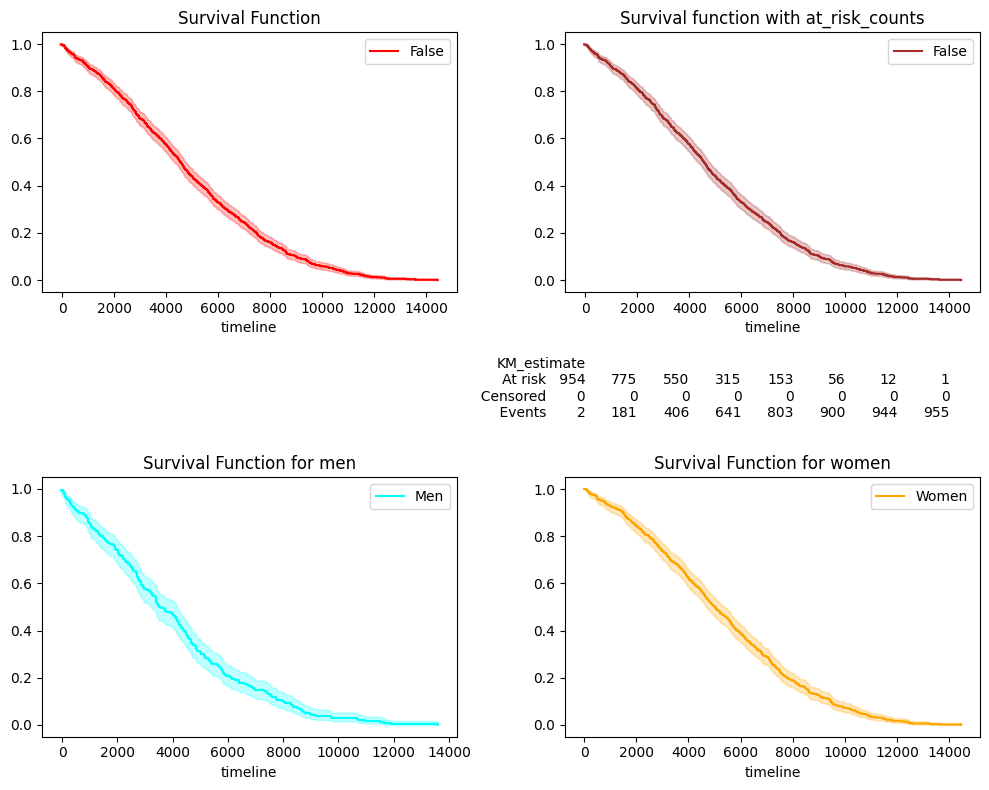

In [75]:
# Representing our survival curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

kmf = KaplanMeierFitter()
kmf.fit(Ts['Ts'], event_observed=E)
kmf.plot_survival_function(ax=axes[0, 0], color = 'red', label = False)
axes[0, 0].set_title('Survival Function')

# Tracer la courbe de survie avec le critère 'at_risk_counts'
kmf.plot_survival_function(ax=axes[0, 1], at_risk_counts=True, color = 'brown', label = False)
axes[0, 1].set_title('Survival function with at_risk_counts')

# Tracer la courbe de survie pour les hommes
sex = Ts['b_sexe'] == 1
kmf.fit(Ts[sex]['Ts'], event_observed= [1]*int(Ts[sex].shape[0]), label="Men")
kmf.plot_survival_function(ax=axes[1, 0], color = 'cyan')
axes[1, 0].set_title('Survival Function for men')

# Tracer la courbe de survie pour les femmes
kmf.fit(Ts[~sex]['Ts'], event_observed= [1]*int(Ts[~sex].shape[0]), label="Women")
kmf.plot_survival_function(ax=axes[1, 1], color = 'orange')
axes[1, 1].set_title('Survival Function for women')

plt.tight_layout()
plt.show()

### With our main data set :

In [76]:
# Download Data

#df = pd.read_stata('Newclones_HF.dta')

#df.to_csv('Newclones_HF.csv')

<ipython-input-76-5035dc3cac0a>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata('Newclones_HF.dta')


In [105]:
# Download Data
df = pd.read_csv('Newclones_HF.csv')

# Keeping the "valid clones"
df = df[df['b_dateD'] >= df['dateA']]

# Create Td and Ts (lifetime in days)
df['Td'] = df['b_dateD'] - df['b_dateN']
df['Ts'] = df['b_dateD'] - df['dateA']

# Create the clone variable which is 1 if the individual is a clone
# and 0 otherwise (individual from the agency dataset)

agency = pd.read_csv('data_tetes_back_match.csv')
df['clone'] = 1

for i in tqdm(agency.index.to_list()):
  id = agency['id'][i]
  prenoms = agency['b_prenoms'][i]
  nom = agency['b_nom'][i]
  sex = agency['b_sexe'][i]

  sub_df = df[df['id']==id]

  for k in sub_df.index.to_list():
    compteur = 0
    if sub_df['b_nom'][k]==nom and sub_df['b_prenoms'][k]==prenoms and sub_df['b_sexe'][k]==sex:
      compteur += 1
      df['clone'][k] = 0

    if compteur > 1:
      print(nom,prenoms)

<ipython-input-105-ace67c4bd737>:2: DtypeWarning: Columns (14,26,41,45,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Newclones_HF.csv')
<ipython-input-105-ace67c4bd737>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Td'] = df['b_dateD'] - df['b_dateN']
<ipython-input-105-ace67c4bd737>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ts'] = df['b_dateD'] - df['dateA']
  0%|          | 0/956 [00:00<?, ?it/s]<ipython-input-105-ace67c4bd737>:29: Sett

In [109]:
# Kaplan-Meier estimation

kmf = KaplanMeierFitter()
Ts = df.sort_values(by = 'Ts',ascending=True)
n = Ts.shape[0]
E = [1]*n
kmf.fit(Ts['Ts'], E)
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.999918
1.0,0.999825
2.0,0.999748
3.0,0.999648
4.0,0.999573
...,...
15331.0,0.000010
15353.0,0.000007
15384.0,0.000005


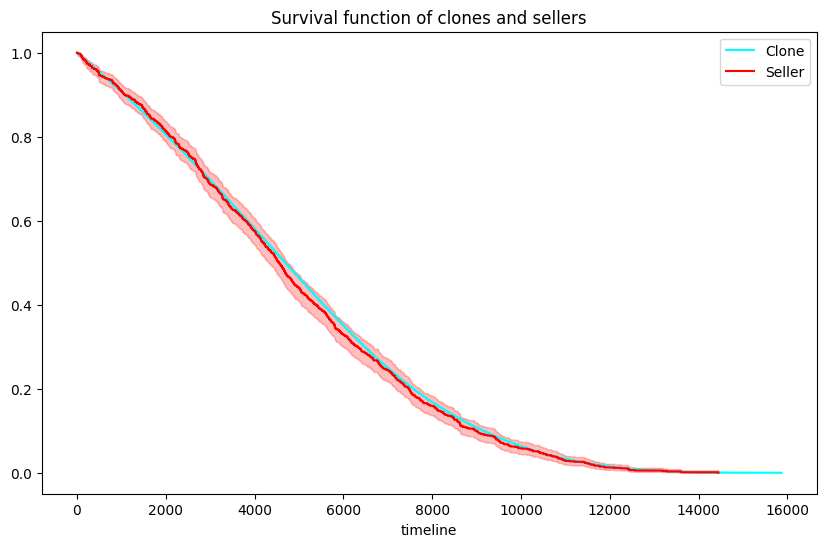

In [112]:
# Representing our survival curves

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(10, 6))

# Divide clones
Clone = Ts[Ts['clone'] == 1]
People = Ts[Ts['clone'] == 0]

# Tracer la courbe de survie pour le groupe 1
kmf.fit(Clone['Ts'], event_observed= [1]*Clone.shape[0])
kmf.plot_survival_function(ax=ax, label='Clone', color = 'cyan')

# Tracer la courbe de survie pour le groupe 2
kmf.fit(People['Ts'], event_observed= [1]*People.shape[0])
kmf.plot_survival_function(ax=ax, label='Seller', color = 'red')

# Ajouter un titre et une légende
ax.set_title('Survival function of clones and sellers')
ax.legend()

plt.show()